# STE Binary Networks

In [1]:
# import torch base code
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from os import path
sys.path.append(path.join("..", "src"))
import torch_base
import matplotlib.pyplot as plt
import subprocess as sub

**Helper Functions**

In [2]:
"""
Function : run_cmd
    
    runs a python script from within python and prints stdout to screen in real-time
    
    Args:
        cmd (string) : command to run as subprocess
        
    Ref: https://stackoverflow.com/questions/17411966/
"""

def run_cmd(cmd):
    
    # create subprocess
    proc = sub.Popen(cmd, stdout=sub.PIPE, universal_newlines=True)
    
    # read output line for line
    while proc.poll() is None:
        
        opt = proc.stdout.readline()
        print(opt)
    
    # print rest of output
    print(proc.stdout.read()) 
    
    return


"""
Function: mfccshow
    
    displays a tensor mfcc
    
        Args:
            mfcc (torch.Tensor) : image tensor (T, Freq)
            title (string)      : plot title
"""


def mfccshow(mfcc, title=''):

    # place image on CPU
    mfcc = mfcc.cpu()

    # plot MFCC
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(mfcc.transpose(0, 1))
    
    print("Mfcc Size (T, Freq) : {}".format(mfcc.size()))

    return

## Data Processing

**MFCC Input Data**

Mfcc Size (T, Freq) : torch.Size([8, 13])


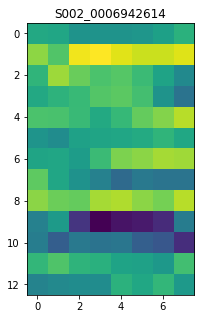

In [21]:
# imports
import torchvision.transforms as tf
from torch.utils.data import DataLoader
from torch_base.process_data import SpeechDataset, Numpy2Tensor, CropSpeech, speech_collate

train_dl = DataLoader(
    
    dataset=SpeechDataset(
        speech_npz='~/Music/ZeroSpeech2019/english/input/test_unsegmented_1_cut.dd.npz',
        transform=tf.Compose([
            Numpy2Tensor(),
            CropSpeech(200, 13)
        ])
    ),
    
    batch_size=1,
    shuffle=False
)

speech_dict = iter(train_dl).next()

# display MFCC
mfccshow(speech_dict["inpt_feat"][0], title=speech_dict["utt_key"][0])

**Filterbank Target Data**

Mfcc Size (T, Freq) : torch.Size([8, 45])


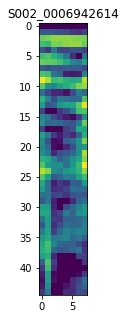

In [16]:
train_dl = DataLoader(
    
    dataset=SpeechDataset(
        speech_npz='~/Music/ZeroSpeech2019/english/target/unsegmented_test_fbank_fftnet_cut.npz',
        transform=tf.Compose([
            Numpy2Tensor(),
            CropSpeech(100, 45)
        ])
    ),
    
    batch_size=1,
    shuffle=False
)

speech_dict = iter(train_dl).next()

# display MFCC
mfccshow(speech_dict["inpt_feat"][0], title=speech_dict["utt_key"][0])

## 1 Layer Linear Rnn Autoencoder

**Train**

In [ ]:
# run Training Script
cmd = " ".join([
    "python ~/Projects/suzerospeech2019/src/torch_base/train.py",
    "--sys",           "MfccAuto",
    "--epochs",           "50",
    "--gamma",            "0.1",
    "--learn_rate",       "0.001",
    "--log",              "~/Music/MfccAuto/logs",
    "--train",            '~/Music/ZeroSpeech2019/english/train.dd.npz',
    "--valid",            '~/Music/ZeroSpeech2019/english/test.dd.npz',
    "--save",             "~/Music/MfccAuto/saved_models",
    "--batch_size",       "100",
    "--bottleneck_depth", "7",
    "--mfcc_width",       "100",
    "--mfcc_height",      "13",
    "--checkpoint",
    "--verbose"   
])

run_cmd(cmd)

Mfcc Size (T, Freq) : torch.Size([7, 45])


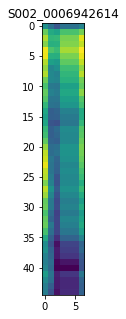

In [17]:
train_dl = DataLoader(
    
    dataset=SpeechDataset(
        speech_npz='~/Music/SpeechAuto/encodings/test/output_feats.npz',
        transform=tf.Compose([
            Numpy2Tensor(),
            CropSpeech(100, 45)
        ])
    ),
    
    batch_size=1,
    shuffle=False
)

speech_dict = iter(train_dl).next()

# display MFCC
mfccshow(speech_dict["inpt_feat"][0], title=speech_dict["utt_key"][0])

ABX : 34.902 
Bitrate : 398.614

## 1 Layer Conv Rnn Autoencoder (Transpose Conv)

Mfcc Size (T, Freq) : torch.Size([7, 45])


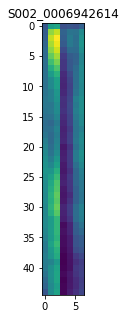

In [19]:
train_dl = DataLoader(
    
    dataset=SpeechDataset(
        speech_npz='~/Music/ConvSpeechAuto/encodings/test/output_feats.npz',
        transform=tf.Compose([
            Numpy2Tensor(),
            CropSpeech(100, 45)
        ])
    ),
    
    batch_size=1,
    shuffle=False
)

speech_dict = iter(train_dl).next()

# display MFCC
mfccshow(speech_dict["inpt_feat"][0], title=speech_dict["utt_key"][0])

ABX: 27.345
Bitrate : 384.844

## 1 Layer Conv Rnn Autoencoder (Pixel Shuffle)